In [16]:
# Cell 1 : Environment Setup and Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Install CatBoost if not available
try:
    import catboost as cb
    from catboost import CatBoostRegressor, Pool
    print("CatBoost already installed")
except ImportError:
    import subprocess
    import sys
    print("Installing CatBoost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "catboost"])
    import catboost as cb
    from catboost import CatBoostRegressor, Pool

import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print("✅ All libraries imported successfully!")
print(f"CatBoost version: {cb.__version__}")

CatBoost already installed
✅ All libraries imported successfully!
CatBoost version: 1.2.8


In [17]:
# Cell 2 : Load and Explore Data
import pandas as pd

# Load the dataset into a DataFrame
df = pd.read_csv('Biomass Data 04_11.csv')
print("📁 Dataset loaded!")

# Display dataset shape and first few rows
print(f"📊 Shape: {df.shape} (rows x columns)")
display(df.head())

# Show column information and data types
print("\n📋 Column info:")
df.info()
print("\n📈 Numerical summary:")
display(df.describe())

# Check for and display columns with missing values
missing_info = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
})
missing_info['Missing_Percentage'] = (missing_info['Missing_Count'] / len(df)) * 100
missing_info = missing_info[missing_info['Missing_Count'] > 0]

if not missing_info.empty:
    print("\n❗ Columns with missing values:")
    display(missing_info)
else:
    print("\n✅ No missing values.")

# Identify potential categorical columns based on unique values
print("\n🏷️  Potential categorical columns:")
for col in df.columns:
    unique_count = df[col].nunique()
    if (unique_count < 20 and df[col].dtype == 'object') or (unique_count < 10 and df[col].dtype in ['int64', 'float64']):
        print(f"{col}: {unique_count} unique → {df[col].unique() if df[col].dtype=='object' else sorted(df[col].unique())}")

# Check for duplicate rows and constant columns
print("\n🔍 Data quality:")
print(f"Duplicate rows: {df.duplicated().sum()}")
constants = [c for c in df.columns if df[c].nunique() == 1]
print(f"Constant columns: {constants if constants else 'None'}")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

# Summarize the target variable ('%Glucose Yield')
target_variable = '%Glucose Yield'
print(f"\n🎯 Target Variable: {target_variable}")
if target_variable in df.columns:
    print(f"Range: {df[target_variable].min():.3f} - {df[target_variable].max():.3f}")
    print(f"Mean: {df[target_variable].mean():.3f}, Std: {df[target_variable].std():.3f}")
else:
    print(f"❌ '{target_variable}' not found in dataset.")

📁 Dataset loaded!
📊 Shape: (533, 32) (rows x columns)


,Reference,Ref No.,System No.,Data Point No.,Figure No. in paper,Index,Feed,Moisture Content (kg water/kg dry biomass),Glucan Content (% dry basis),Hemicellulose Content (% dry basis),...,Conversion Temperature (°C),pH,Enzyme Name,enzyme unit is FPU (Y/N),Enzyme loading (FPU/g dry biomass),Enzyme loading (mg / g glucan),Severity Factor,Microbial Expression Used,% Xylose Yield,%Glucose Yield
0,Gao et al. (2011),R1,S1,D1,Figure -7(A),R1-S1-D1,corn stover,0.6,34.4,22.4,...,50,4.75,Accellerase 1000,N,NaN,3.952602,2.0594,N,3.652094,25.690589
1,Gao et al. (2011),R1,S1,D2,Figure -7(A),R1-S1-D2,corn stover,0.6,34.4,22.4,...,50,4.75,Accellerase 1000,N,NaN,7.916007,2.0594,N,6.370370,41.320834
2,Gao et al. (2011),R1,S1,D3,Figure -7(A),R1-S1-D3,corn stover,0.6,34.4,22.4,...,50,4.75,Accellerase 1000,N,NaN,11.943337,2.0594,N,9.346216,49.141093
3,Gao et al. (2011),R1,S1,D4,Figure -7(A),R1-S1-D4,corn stover,0.6,34.4,22.4,...,50,4.75,Accellerase 1000,N,NaN,15.932726,2.0594,N,12.386473,55.303799
4,Gao et al. (2011),R1,S1,D5,Figure -7(A),R1-S1-D5,corn stover,0.6,34.4,22.4,...,50,4.75,Accellerase 1000,N,NaN,19.945518,2.0594,N,15.491143,60.386704



📋 Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Reference                                      533 non-null    object 
 1   Ref No.                                        533 non-null    object 
 2   System No.                                     533 non-null    object 
 3   Data Point No.                                 533 non-null    object 
 4   Figure No. in paper                            533 non-null    object 
 5   Index                                          533 non-null    object 
 6   Feed                                           533 non-null    object 
 7   Moisture Content (kg water/kg dry biomass)     533 non-null    float64
 8   Glucan Content (% dry basis)                   533 non-null    float64
 9   Hemicellulose Content (% dry basis)   

,Moisture Content (kg water/kg dry biomass),Glucan Content (% dry basis),Hemicellulose Content (% dry basis),Lignin Content (% dry basis),SO2 Concentration (%),CO2 pressure,Ammonia Loading (kg ammonia / kg dry biomass),Hot water solid-to-liquid ratio,Pretreatment Time (h),Pretreatment Temperature (°C),Hydrolysis Time(h),Conversion Temperature (°C),pH,Enzyme loading (FPU/g dry biomass),Enzyme loading (mg / g glucan),Severity Factor,% Xylose Yield,%Glucose Yield
count,533.000000,533.000000,533.000000,504.000000,152.000000,45.000000,30.000000,5.600000e+01,427.000000,427.000000,533.000000,533.000000,504.000000,268.000000,290.000000,427.000000,79.000000,533.000000
mean,0.115019,38.858131,15.991423,16.387017,10.815789,26.666667,1.400000,1.100000e+00,2.330211,136.079625,43.768283,55.384615,5.360714,18.078358,340.694569,2.747085,34.696830,45.678703
std,0.245624,4.721456,7.634175,12.687126,2.808268,6.741999,0.498273,8.962164e-16,5.516006,41.576992,32.112432,22.717046,1.439908,8.057693,606.219013,0.928359,26.634477,28.361783
min,0.000000,16.700000,1.772820,0.651000,3.000000,10.000000,1.000000,1.100000e+00,0.083333,25.000000,0.000000,45.000000,4.750000,10.000000,2.150000,-0.289500,0.845919,0.000000
25%,0.000000,36.903173,6.330374,5.884146,12.000000,30.000000,1.000000,1.100000e+00,0.416667,121.000000,24.000000,50.000000,4.800000,10.000000,25.882500,2.396500,11.974445,23.282350
50%,0.000000,38.900000,19.500000,17.000000,12.000000,30.000000,1.000000,1.100000e+00,0.833333,135.000000,48.000000,50.000000,5.000000,20.000000,54.195881,2.729499,27.388960,36.215565
75%,0.205000,41.940920,21.140000,20.757638,12.000000,30.000000,2.000000,1.100000e+00,1.333333,165.000000,72.000000,50.000000,5.000000,30.000000,60.444282,3.266023,60.476475,72.389180
max,1.500000,43.765240,26.000000,42.000000,12.000000,30.000000,2.000000,1.100000e+00,24.000000,220.000000,168.000000,160.000000,11.500000,30.000000,2395.209000,4.709300,88.002390,98.805350



❗ Columns with missing values:


,Column,Missing_Count,Missing_Percentage
Lignin Content (% dry basis),Lignin Content (% dry basis),29,5.440901
Pre-treatment,Pre-treatment,106,19.887430
Main-Pretreatment Agent,Main-Pretreatment Agent,323,60.600375
SO2 Concentration (%),SO2 Concentration (%),381,71.482176
CO2 pressure,CO2 pressure,488,91.557223
Ammonia Loading (kg ammonia / kg dry biomass),Ammonia Loading (kg ammonia / kg dry biomass),503,94.371482
Hot water solid-to-liquid ratio,Hot water solid-to-liquid ratio,477,89.493433
Pretreatment Time (h),Pretreatment Time (h),106,19.887430
Pretreatment Temperature (°C),Pretreatment Temperature (°C),106,19.887430
pH,pH,29,5.440901



🏷️  Potential categorical columns:
Reference: 9 unique → ['Gao et al. (2011)' 'Kang et al.(2025)' 'Soudham et al(2015)'
 'Banerjee et al,(2011)' 'Benkun Qi(2018)' 'Miao Gao et al. (2010)'
 'Horn et al. (2011)' 'Krishnan et al. (2010)' 'Yamamoto et al. (2014)']
Ref No.: 9 unique → ['R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9']
System No.: 9 unique → ['S1' 'S2' 'S3' 'S4' 'S5' 'S1 -(Black curve)' 'S6' 'S7' 'S8']
Feed: 10 unique → ['corn stover' 'spruce wood' 'Pine stem wood' 'Birch wood'
 'Reed canary grass' 'Pine bark' 'wheat straw' 'rice straw'
 'sugarcane bagasse' 'cane leaf']
Moisture Content (kg water/kg dry biomass): 6 unique → [np.float64(0.0), np.float64(0.1), np.float64(0.11), np.float64(0.205), np.float64(0.6), np.float64(1.5)]
Country of Origin: 4 unique → ['usa' 'sweden' 'china' 'finland']
Pre-treatment: 8 unique → ['AFEX' 'Hot water' nan 'Acid' 'Ionic liquid' 'Alkali' 'SC-CO2'
 'steam explosion' 'SEW fractionation']
Main-Pretreatment Agent: 5 unique → ['ammonia' 'water' nan 

In [18]:
# ===========================================
# Cell 3 : Data Preprocessing for CatBoost
# ===========================================
import numpy as np
import pandas as pd

# Prepare a clean working copy
df_processed = df.copy()

# STEP 1: Select relevant columns
feed_col = 'Feed'
glucose_col = '%Glucose Yield'
try:
    start, end = df_processed.columns.get_loc(feed_col), df_processed.columns.get_loc(glucose_col)
    df_processed = df_processed.iloc[:, start:end+1]
except KeyError as e:
    raise KeyError(f"Column not found: {e}. Verify column names.")

# STEP 2: Handle missing values (CatBoost handles these natively)
missing_info = df_processed.isnull().sum()
total_missing = missing_info.sum()
if total_missing > 0:
    print(f"⚠️ Missing values detected ({total_missing}). CatBoost will handle them automatically.")

# STEP 3: Clean duplicates and constant columns
df_processed = df_processed.drop_duplicates()
constant_cols = [c for c in df_processed.columns if df_processed[c].nunique() == 1]
df_processed = df_processed.drop(columns=constant_cols)

# STEP 4: Quick outlier check (IQR method, informational only)
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
outlier_info = {}
for col in numerical_cols:
    Q1, Q3 = df_processed[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    count = df_processed[(df_processed[col] < lower) | (df_processed[col] > upper)].shape[0]
    if count > 0:
        outlier_info[col] = count
if outlier_info:
    print("Outliers detected (IQR method):", outlier_info)

# STEP 5: Identify categorical features for CatBoost
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
if glucose_col in categorical_cols:
    categorical_cols.remove(glucose_col)
feature_cols = [c for c in df_processed.columns if c != glucose_col]
categorical_indices = [feature_cols.index(c) for c in categorical_cols]

# STEP 6: Split features and target
X = df_processed.drop(columns=[glucose_col])
y = df_processed[glucose_col]

print(f"✅ Preprocessing complete → X: {X.shape}, y: {y.shape}, categorical_features: {categorical_indices}")

⚠️ Missing values detected (3896). CatBoost will handle them automatically.
Outliers detected (IQR method): {'Moisture Content (kg water/kg dry biomass)': 30, 'Glucan Content (% dry basis)': 14, 'SO2 Concentration (%)': 24, 'CO2 pressure': 10, 'Pretreatment Time (h)': 37, 'Pretreatment Temperature (°C)': 30, 'Hydrolysis Time(h)': 12, 'Conversion Temperature (°C)': 33, 'pH': 95, 'Enzyme loading (mg / g glucan)': 70, 'Severity Factor': 38}
✅ Preprocessing complete → X: (533, 24), y: (533,), categorical_features: [0, 5, 6, 7, 13, 17, 18, 22]


In [19]:
# Cell 4 : Train/Test Split
from sklearn.model_selection import train_test_split

# --- TRAIN/TEST SPLIT (Optimized for Small Dataset) ---
random_state = 42
test_size = 0.3  # conservative for small dataset (~380 rows)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state
)

# --- Quick sanity checks ---
# Check for missing values in the split datasets
train_missing = X_train.isnull().sum().sum()
test_missing = X_test.isnull().sum().sum()

# Compare the means and standard deviations of the target variable in train and test sets
mean_diff = abs(y_train.mean() - y_test.mean())
std_diff = abs(y_train.std() - y_test.std())

print(f"✅ Split done: X_train={X_train.shape}, X_test={X_test.shape}")
print(f"   → Missing values: train={train_missing}, test={test_missing}")
print(f"   → Train/test mean diff: {mean_diff:.3f}, std diff: {std_diff:.3f}")
if mean_diff < y_train.std()*0.1 and std_diff < y_train.std()*0.2:
    print("   → Split distributions similar ✅")
else:
    print("   → ⚠️ Train/test distributions differ slightly")

# --- Optional: Validate categorical features exist in splits ---
# Check if categorical features are present in both train and test sets
for idx in categorical_indices:
    if idx < X_train.shape[1]:
        col_name = X_train.columns[idx]
        train_cats = X_train.iloc[:, idx].dropna().nunique()
        test_cats = X_test.iloc[:, idx].dropna().nunique()
        print(f"   → Cat feature {col_name}: {train_cats} train, {test_cats} test categories")

# Ensure categorical columns are strings and fix NaNs for CatBoost
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype(str).fillna('Unknown')
    X_test[col] = X_test[col].astype(str).fillna('Unknown')

# Prepare categorical features list for CatBoost
categorical_features_fixed = X_train.select_dtypes(include=['object']).columns.tolist()

✅ Split done: X_train=(373, 24), X_test=(160, 24)
   → Missing values: train=2422, test=997
   → Train/test mean diff: 2.222, std diff: 0.050
   → Split distributions similar ✅
   → Cat feature Feed: 10 train, 10 test categories
   → Cat feature Country of Origin: 4 train, 4 test categories
   → Cat feature Pre-treatment: 8 train, 8 test categories
   → Cat feature Main-Pretreatment Agent: 5 train, 5 test categories
   → Cat feature Hydrolysis Method: 2 train, 2 test categories
   → Cat feature Enzyme Name: 2 train, 2 test categories
   → Cat feature enzyme unit is FPU (Y/N): 2 train, 2 test categories
   → Cat feature Microbial Expression Used: 2 train, 2 test categories


In [20]:
# Cell 5 : Train CatBoost Model
from catboost import CatBoostRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the CatBoost Regressor model
model = CatBoostRegressor(
    iterations=400,
    learning_rate=0.145,
    depth=4,
    l2_leaf_reg=1.7,
    random_seed=42,
    task_type='GPU',
    devices='0',
    verbose=25,
    use_best_model=True,
    #early_stopping_rounds=40
)
# Train the model on the training data
training_start = datetime.now()
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    cat_features=categorical_features_fixed,
    verbose=25
)
training_end = datetime.now()
# Save the trained model
model.save_model("catboost_model.cbm")
print(f"✅ Training completed in {(training_end-training_start).total_seconds():.1f}s")
# ----------------------
# RMSE Gap / Overfitting Check
# ----------------------
# Make predictions on both training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
# Calculate the difference in RMSE between test and train
rmse_diff = test_rmse - train_rmse
if rmse_diff > 1.0:
    alert = "⚠️ Overfitting detected!"
    color_start = "\033[91m"
elif rmse_diff > 0.5:
    alert = "⚠️ Mild overfitting"
    color_start = "\033[93m"
else:
    alert = "✅ Minimal overfitting"
    color_start = "\033[92m"
color_end = "\033[0m"
print(f"\n🔍 RMSE Analysis:")
print(f"   → Train RMSE: {train_rmse:.3f}")
print(f"   → Test RMSE:  {test_rmse:.3f}")
print(f"   → RMSE Gap (Test - Train): {rmse_diff:.3f}")
print(f"   → {color_start}{alert}{color_end}")
# Save the model to a JSON file
model_filename = "catboost_glucose_yield_model.json"
model.save_model(model_filename)
print(f"\n💾 Model saved to {model_filename}")

0:	learn: 25.8227080	test: 26.2800851	best: 26.2800851 (0)	total: 25.9ms	remaining: 10.3s
25:	learn: 10.9725516	test: 14.3988084	best: 14.3988084 (25)	total: 1.07s	remaining: 15.5s
50:	learn: 9.1221619	test: 12.1980663	best: 12.1980663 (50)	total: 1.3s	remaining: 8.91s
75:	learn: 8.0361545	test: 10.9861268	best: 10.9861268 (75)	total: 1.51s	remaining: 6.45s
100:	learn: 7.0910743	test: 9.9508018	best: 9.9508018 (100)	total: 1.78s	remaining: 5.28s
125:	learn: 6.5763482	test: 9.6245542	best: 9.5694365 (122)	total: 1.98s	remaining: 4.3s
150:	learn: 6.1686194	test: 9.2781278	best: 9.2669934 (149)	total: 2.2s	remaining: 3.63s
175:	learn: 5.7483688	test: 9.1144932	best: 9.1127654 (173)	total: 2.43s	remaining: 3.1s
200:	learn: 5.4373982	test: 9.0612890	best: 8.9894293 (193)	total: 2.65s	remaining: 2.63s
225:	learn: 5.1241718	test: 8.9016062	best: 8.8915922 (224)	total: 2.9s	remaining: 2.23s
250:	learn: 4.8952676	test: 8.9318406	best: 8.8892155 (232)	total: 3.1s	remaining: 1.84s
275:	learn: 4.5

📊 CATBOOST MODEL EVALUATION

📌 Training Performance:
   → RMSE: 7.97, MAE: 3.94, R²: 0.921, MAPE: 12.7%
   → Pearson Corr: 0.961 (p=1.13e-208)

📌 Test Performance:
   → RMSE: 8.74, MAE: 5.09, R²: 0.904, MAPE: 20.4%
   → Pearson Corr: 0.951 (p=1.41e-82)

🔍 Overfitting Check: R² gap = 0.017
   ✅ Minimal overfitting


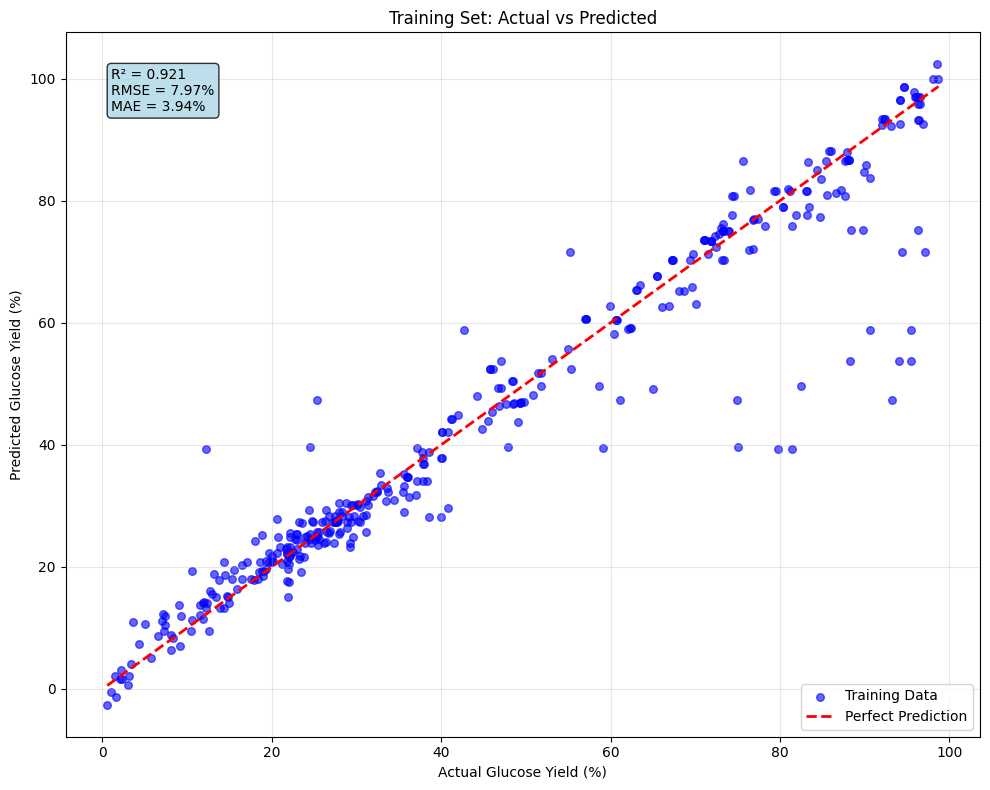

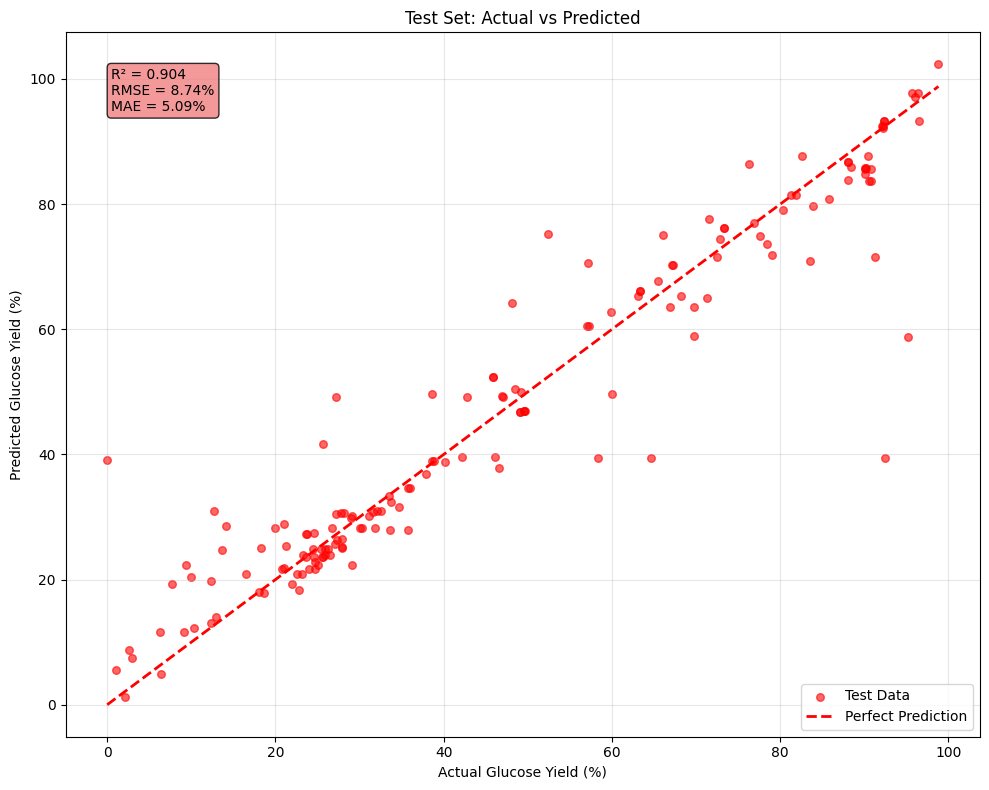

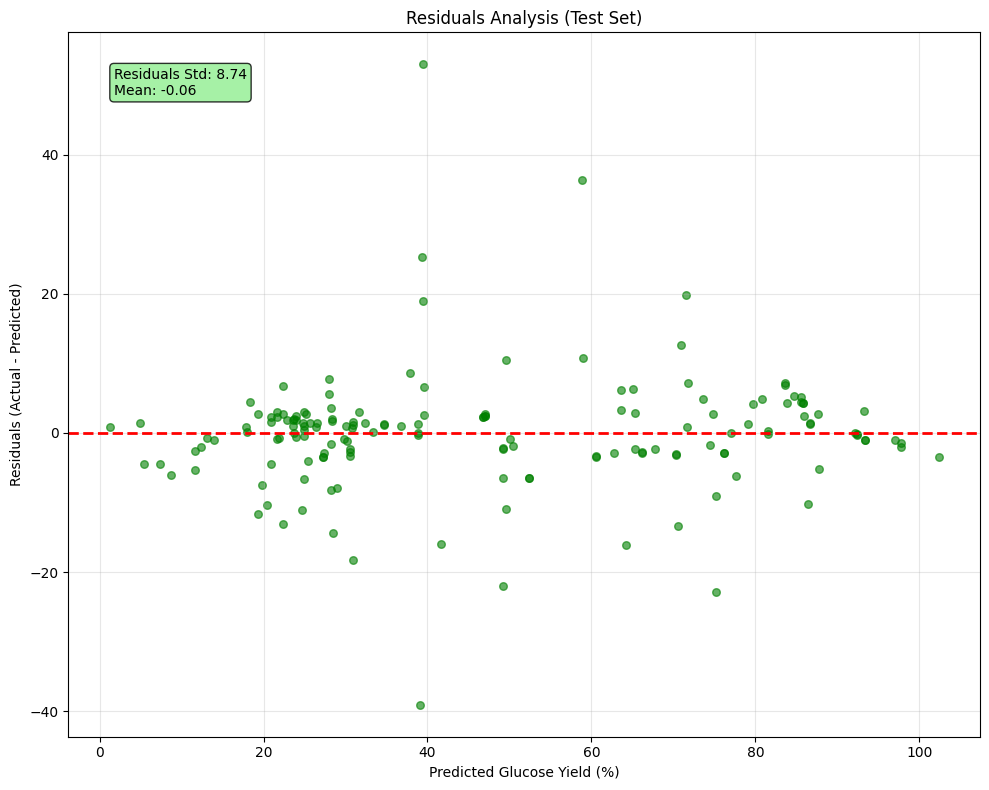

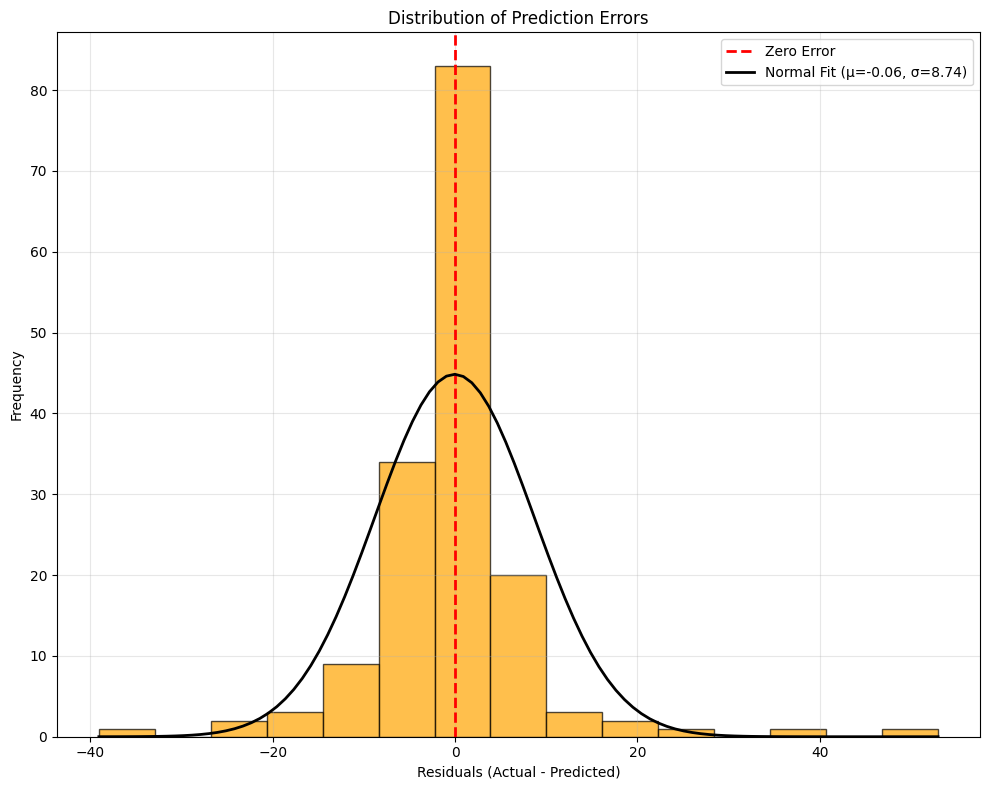


🔍 Top 10 Features by Importance:
                                Feature  Importance
17                          Enzyme Name   27.392789
14                   Hydrolysis Time(h)   16.946177
21                      Severity Factor   16.034444
20       Enzyme loading (mg / g glucan)    6.276407
3   Hemicellulose Content (% dry basis)    4.878240
11                Pretreatment Time (h)    4.564089
12        Pretreatment Temperature (°C)    3.023843
4          Lignin Content (% dry basis)    2.885804
16                                   pH    2.773755
7               Main-Pretreatment Agent    2.033184


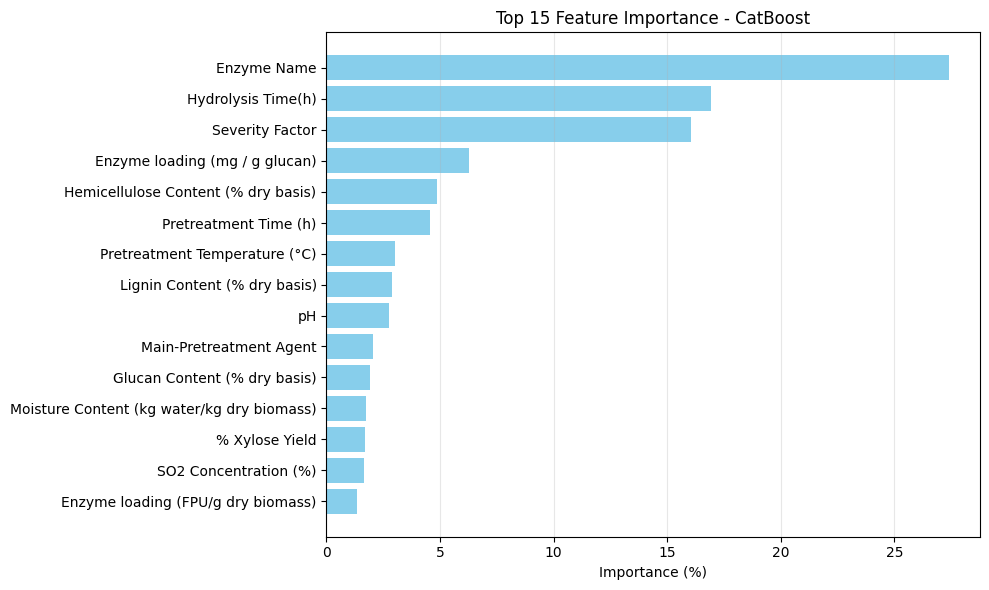


✅ All CatBoost evaluation plots saved in 'catboost_plots/' directory.


In [21]:
# Cell 6: CatBoost Model Evaluation and Visualization
print("📊 CATBOOST MODEL EVALUATION")
print("=" * 50)
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, norm
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Create a directory for saving plots (overwrites old ones)
os.makedirs('catboost_plots', exist_ok=True)

# Predictions on both sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Mean Absolute Percentage Error (ignores very small targets)
def calculate_mape(y_true, y_pred):
    mask = y_true > 1
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.sum(mask) > 0 else np.nan

# Helper to print core regression metrics
def print_metrics(y_true, y_pred, name="Dataset"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)
    corr, p_val = pearsonr(y_true, y_pred)

    print(f"\n📌 {name} Performance:")
    print(f"   → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}, MAPE: {mape:.1f}%")
    print(f"   → Pearson Corr: {corr:.3f} (p={p_val:.2e})")
    return r2, rmse, mae

# Evaluate both sets
train_r2, train_rmse, train_mae = print_metrics(y_train, y_train_pred, "Training")
test_r2, test_rmse, test_mae = print_metrics(y_test, y_test_pred, "Test")

# Overfitting sanity check
r2_diff = train_r2 - test_r2
print(f"\n🔍 Overfitting Check: R² gap = {r2_diff:.3f}")
if r2_diff > 0.1:
    print("   ⚠️ Significant overfitting")
elif r2_diff > 0.05:
    print("   ⚠️ Moderate overfitting")
else:
    print("   ✅ Minimal overfitting")

# --- Plot 1: Actual vs Predicted (Training) ---
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(y_train, y_train_pred, alpha=0.6, color='blue', s=30, label='Training Data')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel("Actual Glucose Yield (%)")
ax1.set_ylabel("Predicted Glucose Yield (%)")
ax1.set_title("Training Set: Actual vs Predicted")
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.text(0.05, 0.95, f'R² = {train_r2:.3f}\nRMSE = {train_rmse:.2f}%\nMAE = {train_mae:.2f}%',
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
plt.tight_layout()
plt.savefig('catboost_plots/01_training_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 2: Actual vs Predicted (Test) ---
fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(y_test, y_test_pred, alpha=0.6, color='red', s=30, label='Test Data')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel("Actual Glucose Yield (%)")
ax2.set_ylabel("Predicted Glucose Yield (%)")
ax2.set_title("Test Set: Actual vs Predicted")
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.text(0.05, 0.95, f'R² = {test_r2:.3f}\nRMSE = {test_rmse:.2f}%\nMAE = {test_mae:.2f}%',
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
plt.tight_layout()
plt.savefig('catboost_plots/02_test_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 3: Residuals Analysis (Test Set) ---
residuals_test = y_test - y_test_pred
fig3, ax3 = plt.subplots(figsize=(10, 8))
ax3.scatter(y_test_pred, residuals_test, alpha=0.6, color='green', s=30)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Glucose Yield (%)')
ax3.set_ylabel('Residuals (Actual - Predicted)')
ax3.set_title('Residuals Analysis (Test Set)')
ax3.grid(True, alpha=0.3)
residuals_std = np.std(residuals_test)
ax3.text(0.05, 0.95, f'Residuals Std: {residuals_std:.2f}\nMean: {np.mean(residuals_test):.2f}',
         transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
plt.tight_layout()
plt.savefig('catboost_plots/03_residuals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 4: Distribution of Prediction Errors ---
fig4, ax4 = plt.subplots(figsize=(10, 8))
ax4.hist(residuals_test, bins=15, alpha=0.7, color='orange', edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax4.set_xlabel('Residuals (Actual - Predicted)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Prediction Errors')
ax4.grid(True, alpha=0.3)

# Fit a normal curve to visualize error distribution
mu, sigma = stats.norm.fit(residuals_test)
x = np.linspace(residuals_test.min(), residuals_test.max(), 100)
y = stats.norm.pdf(x, mu, sigma) * len(residuals_test) * (residuals_test.max() - residuals_test.min()) / 15
ax4.plot(x, y, 'k-', linewidth=2, label=f'Normal Fit (μ={mu:.2f}, σ={sigma:.2f})')
ax4.legend()
plt.tight_layout()
plt.savefig('catboost_plots/04_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 5: Feature Importance ---
feat_imp = model.get_feature_importance()
feat_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': feat_imp})
importance_df['Importance'] = 100 * importance_df['Importance'] / importance_df['Importance'].sum()
importance_df = importance_df.sort_values('Importance', ascending=False)

print("\n🔍 Top 10 Features by Importance:")
print(importance_df.head(10))

fig5, ax5 = plt.subplots(figsize=(10, 6))
top15 = importance_df.head(15)
ax5.barh(top15['Feature'], top15['Importance'], color='skyblue')
ax5.invert_yaxis()
ax5.set_xlabel("Importance (%)")
ax5.set_title("Top 15 Feature Importance - CatBoost")
ax5.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('catboost_plots/05_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ All CatBoost evaluation plots saved in 'catboost_plots/' directory.")


🔍 DETECTING PREDICTION OUTLIERS

Training Set:
   → Outliers detected: 30 (8.0%)
   → Residual bounds: [-8.33, 8.52]

Test Set:
   → Outliers detected: 16 (10.0%)
   → Residual bounds: [-11.17, 10.95]

📋 Training Set Outliers (30 rows):
    Index             Reference   Actual  Predicted   Residual      APE_%
 R3-S3-D9   Soudham et al(2015) 12.25071  39.360786 -27.110076 221.293920
 R3-S4-D9   Soudham et al(2015) 25.35211  47.380610 -22.028500  86.890203
 R4-S1-D2 Banerjee et al,(2011) 10.59000  19.278694  -8.688694  82.046218
R3-S1-D10   Soudham et al(2015) 24.46237  39.596215 -15.133845  61.865818
 R3-S3-D6   Soudham et al(2015) 81.48148  39.360786  42.120694  51.693579
 R3-S3-D3   Soudham et al(2015) 79.77208  39.360786  40.411294  50.658443
 R3-S4-D6   Soudham et al(2015) 93.23944  47.380610  45.858830  49.183940
 R3-S1-D4   Soudham et al(2015) 75.00000  39.596215  35.403785  47.205046
 R3-S3-D8   Soudham et al(2015) 95.44160  53.742380  41.699220  43.690823
 R3-S3-D5   Soudham et

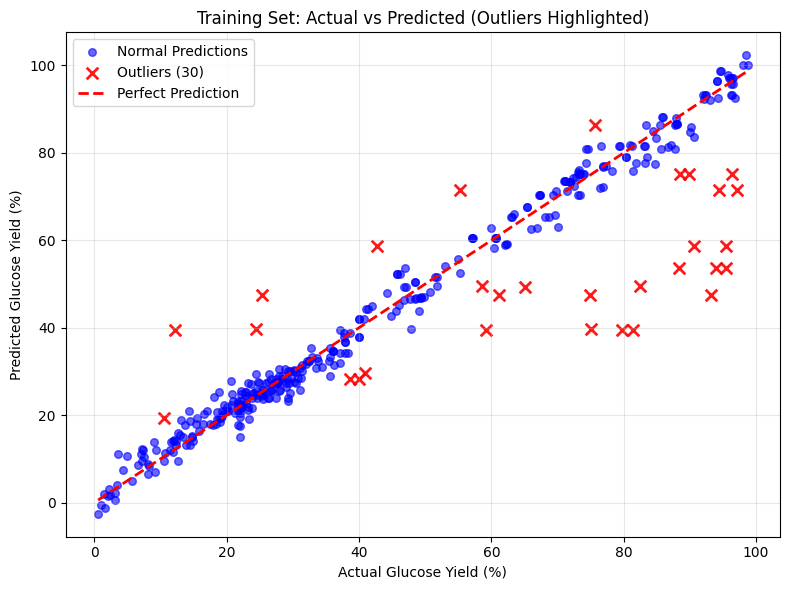

✅ Saved plot: catboost_plots/train_outliers_plot.png


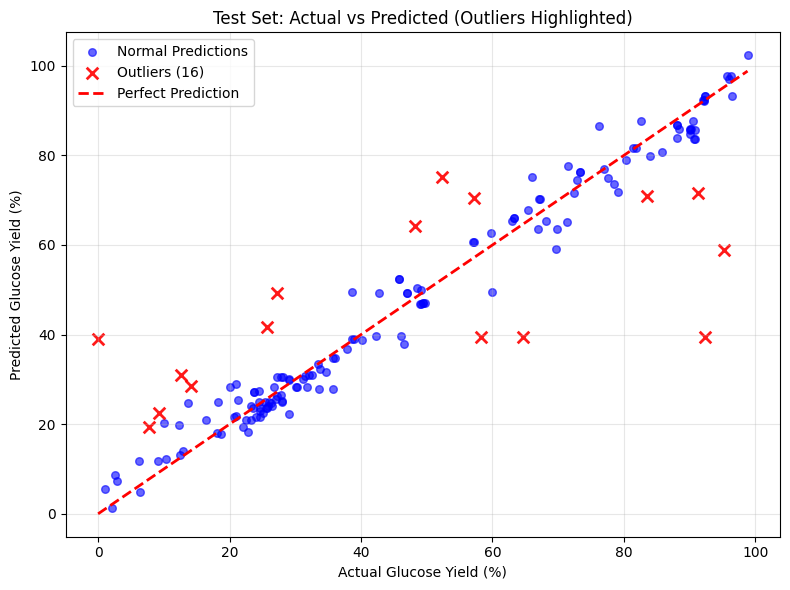

✅ Saved plot: catboost_plots/test_outliers_plot.png

✅ Outlier detection and visualization complete!


In [22]:
# ============================================================
# Cell 6.5: Outlier Detection (IQR Method) + Visualization
# ============================================================
print("\n🔍 DETECTING PREDICTION OUTLIERS")
print("=" * 60)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Compute residuals and APE
# -----------------------------
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred
train_ape = np.abs((y_train - y_train_pred) / y_train) * 100
test_ape = np.abs((y_test - y_test_pred) / y_test) * 100

# -----------------------------
# 2. IQR-based outlier detection
# -----------------------------
def detect_outliers_iqr(residuals, dataset_name="Dataset"):
    Q1 = np.percentile(residuals, 25)
    Q3 = np.percentile(residuals, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = (residuals < lower_bound) | (residuals > upper_bound)
    outlier_count = np.sum(outlier_mask)
    outlier_percentage = (outlier_count / len(residuals)) * 100
    print(f"\n{dataset_name}:")
    print(f"   → Outliers detected: {outlier_count} ({outlier_percentage:.1f}%)")
    print(f"   → Residual bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    return outlier_mask

train_outliers_iqr = detect_outliers_iqr(train_residuals, "Training Set")
test_outliers_iqr = detect_outliers_iqr(test_residuals, "Test Set")

# -----------------------------
# 3. Outlier DataFrames with Reference + Index
# -----------------------------
train_outlier_indices = y_train[train_outliers_iqr].index.tolist()
test_outlier_indices = y_test[test_outliers_iqr].index.tolist()

# Ensure "Index" exists in df
if "Index" not in df.columns:
    raise ValueError("❌ Column 'Index' not found in the original dataframe!")

train_outliers_df = pd.DataFrame({
    'Row_Number': train_outlier_indices,
    'Index': df.loc[train_outlier_indices, 'Index'].values,
    'Reference': df.loc[train_outlier_indices, 'Reference'].values,
    'Actual': y_train[train_outliers_iqr].values,
    'Predicted': y_train_pred[train_outliers_iqr],
    'Residual': train_residuals[train_outliers_iqr].values,
    'APE_%': train_ape[train_outliers_iqr].values
}).sort_values('APE_%', ascending=False)

test_outliers_df = pd.DataFrame({
    'Row_Number': test_outlier_indices,
    'Index': df.loc[test_outlier_indices, 'Index'].values,
    'Reference': df.loc[test_outlier_indices, 'Reference'].values,
    'Actual': y_test[test_outliers_iqr].values,
    'Predicted': y_test_pred[test_outliers_iqr],
    'Residual': test_residuals[test_outliers_iqr].values,
    'APE_%': test_ape[test_outliers_iqr].values
}).sort_values('APE_%', ascending=False)

# -----------------------------
# 4. Print Outlier DataFrames
# -----------------------------
print(f"\n📋 Training Set Outliers ({len(train_outliers_df)} rows):")
print(train_outliers_df[['Index', 'Reference', 'Actual', 'Predicted', 'Residual', 'APE_%']].to_string(index=False))

print(f"\n📋 Test Set Outliers ({len(test_outliers_df)} rows):")
print(test_outliers_df[['Index', 'Reference', 'Actual', 'Predicted', 'Residual', 'APE_%']].to_string(index=False))

# -----------------------------
# 5. Save Results
# -----------------------------
train_outliers_df.to_csv('catboost_plots/train_outliers.csv', index=False)
test_outliers_df.to_csv('catboost_plots/test_outliers.csv', index=False)
print(f"\n✅ Outliers saved to:")
print(f"   → 'catboost_plots/train_outliers.csv'")
print(f"   → 'catboost_plots/test_outliers.csv'")

# -----------------------------
# 6. Visualize Train/Test Outliers
# -----------------------------
print("\n📊 Generating outlier visualizations...")

def plot_outliers(actual, predicted, outlier_mask, dataset_name, save_path):
    plt.figure(figsize=(8, 6))
    plt.scatter(actual[~outlier_mask], predicted[~outlier_mask],
                alpha=0.6, color='blue', s=30, label='Normal Predictions')
    plt.scatter(actual[outlier_mask], predicted[outlier_mask],
                alpha=0.9, color='red', s=70, marker='x', linewidths=2,
                label=f'Outliers ({np.sum(outlier_mask)})')
    plt.plot([actual.min(), actual.max()],
             [actual.min(), actual.max()],
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Glucose Yield (%)')
    plt.ylabel('Predicted Glucose Yield (%)')
    plt.title(f'{dataset_name}: Actual vs Predicted (Outliers Highlighted)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved plot: {save_path}")

plot_outliers(y_train, y_train_pred, train_outliers_iqr,
              "Training Set", 'catboost_plots/train_outliers_plot.png')
plot_outliers(y_test, y_test_pred, test_outliers_iqr,
              "Test Set", 'catboost_plots/test_outliers_plot.png')

print("\n✅ Outlier detection and visualization complete!")

In [23]:
# Cell 7: Export Metrics to Excel (Neat, Append-Safe, Auto-Formatted)

import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import skew, kurtosis, pearsonr
from openpyxl import load_workbook
from openpyxl.styles import Alignment
from openpyxl.utils import get_column_letter

# Install openpyxl if missing
try:
    import openpyxl
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])
    import openpyxl

print("💾 EXPORTING METRICS TO EXCEL")
print("=" * 60)

# --- SETTINGS ---
MODEL_NAME = 'CatBoost'  # ← Change per model
excel_file = 'Model_Comparison_Results.xlsx'

# --- CALCULATE METRICS ---
train_mape = calculate_mape(y_train, y_train_pred)
test_mape = calculate_mape(y_test, y_test_pred)
train_corr, _ = pearsonr(y_train, y_train_pred)
test_corr, _ = pearsonr(y_test, y_test_pred)
rmse_diff = test_rmse - train_rmse

metrics_data = {
    'Model': MODEL_NAME,
    'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),

    # Train Metrics
    'Train_RMSE': train_rmse,
    'Train_MAE': train_mae,
    'Train_R2': train_r2,
    'Train_MAPE': train_mape,
    'Train_Pearson': train_corr,

    # Test Metrics
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae,
    'Test_R2': test_r2,
    'Test_MAPE': test_mape,
    'Test_Pearson': test_corr,

    # Overfitting
    'R2_Gap': r2_diff,
    'RMSE_Gap': rmse_diff,
    'Overfitting_Level': 'Significant' if r2_diff > 0.1 else ('Moderate' if r2_diff > 0.05 else 'Minimal'),

    # Residual Stats
    'Residuals_Mean': np.mean(residuals_test),
    'Residuals_Std': np.std(residuals_test),
    'Residuals_Min': np.min(residuals_test),
    'Residuals_Max': np.max(residuals_test),
    'Residuals_Q25': np.percentile(residuals_test, 25),
    'Residuals_Q75': np.percentile(residuals_test, 75),
    'Residuals_Skewness': skew(residuals_test),
    'Residuals_Kurtosis': kurtosis(residuals_test),

    # Error Distribution
    'Within_2pct': (np.abs(residuals_test) <= 2).sum() / len(residuals_test) * 100,
    'Within_5pct': (np.abs(residuals_test) <= 5).sum() / len(residuals_test) * 100,
    'Within_10pct': (np.abs(residuals_test) <= 10).sum() / len(residuals_test) * 100,

    # Dataset Info
    'Train_Samples': len(y_train),
    'Test_Samples': len(y_test),
    'N_Features': X_train.shape[1]
}

metrics_df = pd.DataFrame([metrics_data])

# --- EXPORT TO EXCEL ---
try:
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
        existing_metrics = pd.read_excel(excel_file, sheet_name='Metrics')
        existing_metrics = existing_metrics[existing_metrics['Model'] != MODEL_NAME]
        combined_metrics = pd.concat([existing_metrics, metrics_df], ignore_index=True)

        combined_metrics.to_excel(writer, sheet_name='Metrics', index=False)
        importance_df.head(15).to_excel(writer, sheet_name=f'{MODEL_NAME}_Features', index=False)

    print(f"✅ Updated existing file: {excel_file}")

except FileNotFoundError:
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='w') as writer:
        metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
        importance_df.head(15).to_excel(writer, sheet_name=f'{MODEL_NAME}_Features', index=False)

    print(f"✅ Created new file: {excel_file}")

# --- NEAT FORMATTING (auto width + wrap text) ---
wb = load_workbook(excel_file)
for sheet in wb.sheetnames:
    ws = wb[sheet]
    for col in ws.columns:
        max_len = 0
        col_letter = col[0].column_letter
        for cell in col:
            if cell.value:
                max_len = max(max_len, len(str(cell.value)))
            cell.alignment = Alignment(wrap_text=True, vertical='top')
        ws.column_dimensions[col_letter].width = min(max_len + 2, 50)  # limit max width

wb.save(excel_file)

print(f"✅ Metrics and features neatly formatted in '{excel_file}'")
print("=" * 60)

💾 EXPORTING METRICS TO EXCEL
✅ Updated existing file: Model_Comparison_Results.xlsx
✅ Metrics and features neatly formatted in 'Model_Comparison_Results.xlsx'
